In [159]:
# loading the mnist dataset
from tensorflow.keras.datasets.mnist import load_data

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import tensorflow as tf

from IPython import display

In [160]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt


def load_image_numpy_arys(folder):
  images = []
  count = 115
  for i in os.listdir(folder):
    img_path = os.path.join(folder,i)
    img = cv2.imread(img_path,0)
    img = cv2.resize(img,(400,200))
    # img = np.asarray(img)
    # img = img.reshape(600,600)
    images.append(img)
    count -= 1
    print(count,end='-')
    # break
    
  return images

In [161]:
pcb_images = load_image_numpy_arys("/home/mtech/mushtaq.islam/files/object_detection/arohi/Generative-Adversarial-Network-for-an-MNIST-Handwritten-Digits-From-Scratch-in-Keras/pcb")

114-113-112-111-110-109-108-107-106-105-104-103-102-101-100-99-98-97-96-95-94-93-92-91-90-89-88-87-86-85-84-83-82-81-80-79-78-77-76-75-74-73-72-71-70-69-68-67-66-65-64-63-62-61-60-59-58-57-56-55-54-53-52-51-50-49-48-47-46-45-44-43-42-41-40-39-38-37-36-35-34-33-32-31-30-29-28-27-26-25-24-23-22-21-20-19-18-17-16-15-14-13-12-11-10-9-8-7-6-5-4-3-2-1-0-

In [162]:
pcb_images = np.asarray(pcb_images)

In [163]:
pcb_images.shape

(115, 200, 400)

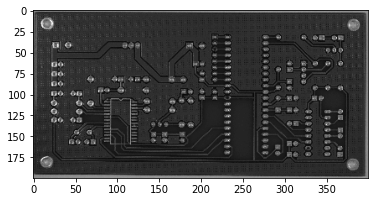

In [164]:
plt.imshow(pcb_images[0],cmap="gray")

In [165]:
# from PIL import Image
# from numpy import asarray
# # load the image
# image = Image.open('/content/drive/MyDrive/Taiwan/customTF1/data/images/l_light_01_missing_hole_01_1_600.jpg')
# # convert image to numpy array
# data = asarray(image)
# print(type(data))
# # summarize shape
# print(data.shape)

# # create Pillow image
# image2 = Image.fromarray(data)
# print(type(image2))

# # summarize image details
# print(image2.mode)
# print(image2.size)

In [166]:
#plot of 25 images from the MNIST training dataset, arranged in a 5×5 square.


from tensorflow.keras.datasets.mnist import load_data
from matplotlib import pyplot
# load the images into memory
# (trainX, trainy), (testX, testy) = load_data()
# # plot images from the training dataset
# for i in range(25):
# 	# define subplot
# 	pyplot.subplot(5, 5, 1 + i)
# 	# turn off axis
# 	pyplot.axis('off')
# 	# plot raw pixel data
# 	pyplot.imshow(trainX[i], cmap='gray_r')
# pyplot.show()

In [167]:
# train_images = pcb_images.reshape(pcb_images.shape[0], 28, 28, 1).astype('float32')
# (train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_datrain_images
pcb_images.shape

(115, 200, 400)

In [168]:
# (train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

pcb_images = (pcb_images - 127.5) / 127.5  # Normalize the images to [-1, 1]
BUFFER_SIZE = 40000
BATCH_SIZE = 16
# Batch and shuffle the data
pcb_images = tf.data.Dataset.from_tensor_slices(pcb_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [169]:
type(pcb_images)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [170]:
# input 7*7*256 (low resolution version of the output image)
# outputs a single 28×28 grayscale image
# this generator takes a vector of size 100 and first reshape that into (7, 7, 128) vector then applied transpose 
# convolution in combination with batch normalization. 


def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(50*100*256,use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((50, 100, 256)))
    assert model.output_shape == (None, 50, 100, 256)  # Note: None is the batch size
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same',use_bias = False))
    assert model.output_shape == (None, 50, 100, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

  # # # #  # upsample to 14x14
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same',use_bias= False))
    assert model.output_shape == (None, 100, 200, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

  #   model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same'))
  #   assert model.output_shape == (None, 200, 400, 64)
  #   model.add(layers.BatchNormalization())
  #   model.add(layers.LeakyReLU())
    
  # # # #   # upsample to 28x28
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='tanh',use_bias= False))
    assert model.output_shape == (None, 200, 400, 1)

    return model

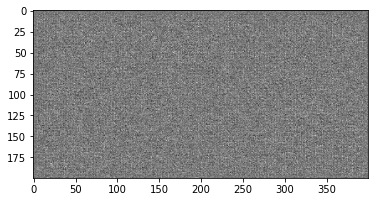

In [171]:
# sample image generated by the the generator
generator = make_generator_model()

noise = tf.random.normal([1,100]) #latent space
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [172]:
generated_image.shape

TensorShape([1, 200, 400, 1])

In [173]:
# Input to discriminator = 800*1200*1   grayscale image
# Output  binary prediction (image is real (class=1) or fake (class=0))
# no pooling layers  
# single node in the output layer with the sigmoid activation function to predict whether the input sample is real or fake. 

def make_discriminator_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',input_shape=[200, 400, 1])) #2×2 stride to downsample
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')) #downsampling  2×2 stride to downsample
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')) #downsampling  2×2 stride to downsample
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')) #downsampling  2×2 stride to downsample
    # model.add(layers.LeakyReLU())
    # model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())  # classifier real (class=1) or fake (class=0))
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [174]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.49998802]], shape=(1, 1), dtype=float32)


In [175]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [176]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [177]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [178]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [179]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)



In [180]:
EPOCHS = 500
noise_dim = 100
num_examples_to_generate = 1

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [181]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [182]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 100 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [183]:
cd /home/mtech/mushtaq.islam/files/object_detection/arohi/Generative-Adversarial-Network-for-an-MNIST-Handwritten-Digits-From-Scratch-in-Keras/pcb_results/pcb_result_200_400

/home/mtech/mushtaq.islam/files/object_detection/arohi/Generative-Adversarial-Network-for-an-MNIST-Handwritten-Digits-From-Scratch-in-Keras/pcb_results/pcb_result_200_400


In [184]:
pwd

'/home/mtech/mushtaq.islam/files/object_detection/arohi/Generative-Adversarial-Network-for-an-MNIST-Handwritten-Digits-From-Scratch-in-Keras/pcb_results/pcb_result_200_400'

In [185]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(8, 8))

  for i in range(predictions.shape[0]):
      # plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
      plt.axis('off')
  if epoch % 50 == 0:
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [186]:

checkpoint.restore('/home/mtech/mushtaq.islam/files/object_detection/arohi/Generative-Adversarial-Network-for-an-MNIST-Handwritten-Digits-From-Scratch-in-Keras/pcb_results/pcb_result_200_400/training_checkpoints/ckpt-14')

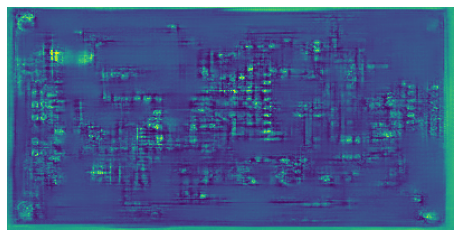

Time for epoch 216 is 29.339646339416504 sec


In [187]:
train(pcb_images, EPOCHS)